In [ ]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import util
from util import inv_phi_range
from util import FWHM
from util import calculate_phi
import model as m

from tensorflow import keras
from tensorflow.keras import layers
from keras.engine import data_adapter

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tqdm.auto import tqdm


/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
teacher_hidden_neurons = 256
student_hidden_neurons = 8
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [18, 5]
device = 0
n_epochs     = 100
batch_size   = 1024
corrector_hidden_neurons = 4

In [3]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


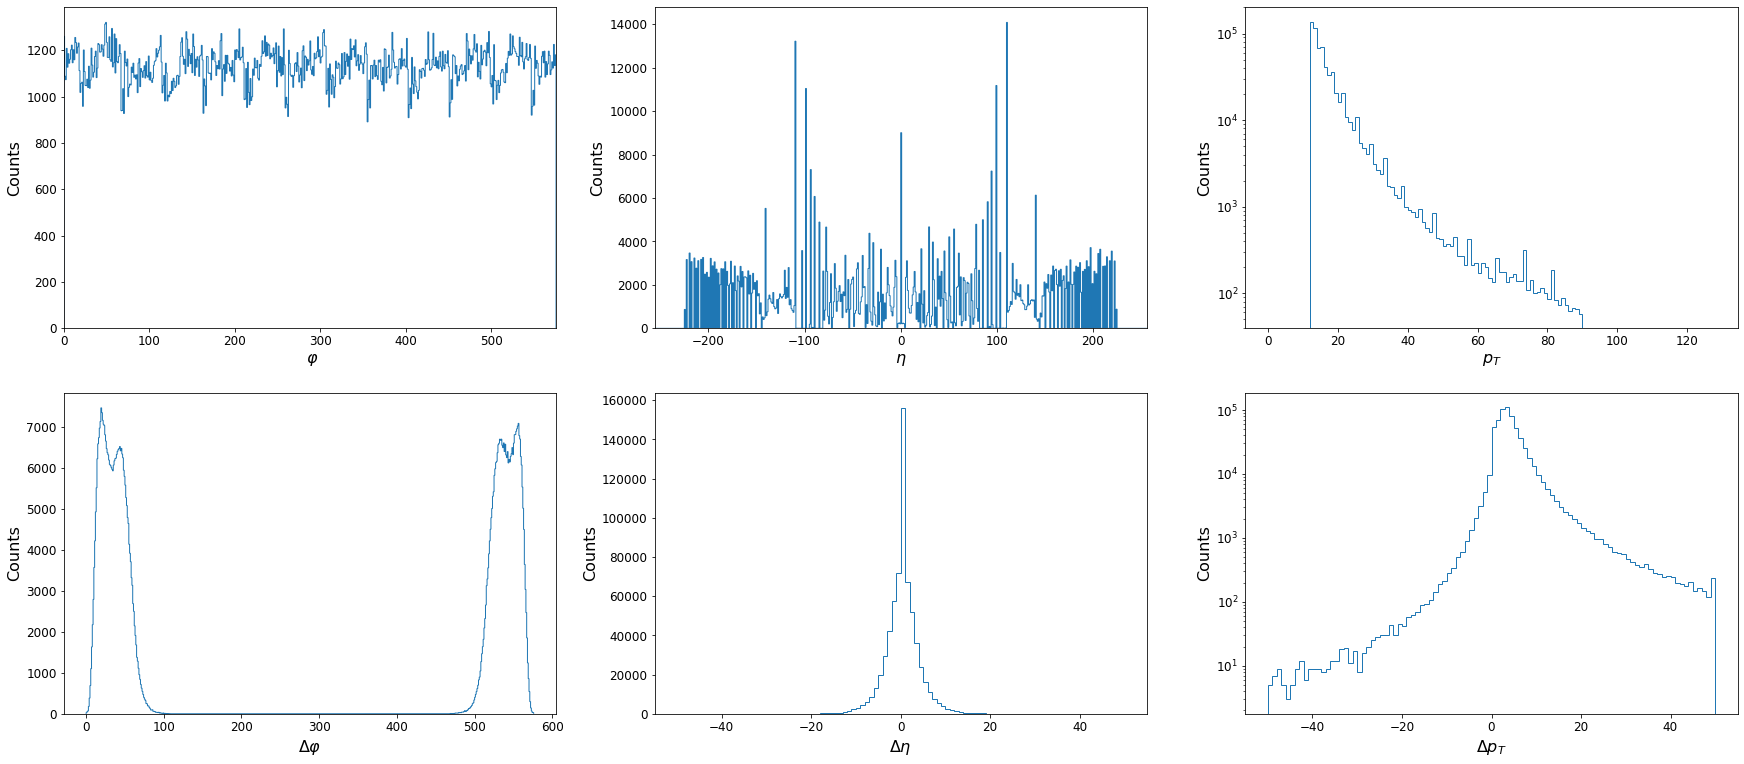

In [4]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [9]:
teacher = m.make_model(hidden_neurons=teacher_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

student =  m.make_model(hidden_neurons=student_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

2023-08-07 16:31:09.976898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 16:31:11.066527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10028 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-08-07 16:31:11.068004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10140 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [10]:
teacher.load_weights("./checkpoints/teacher.h5")

In [11]:
student = tf.keras.models.load_model('student-recalibration/best/')

2023-08-07 16:31:15.980822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


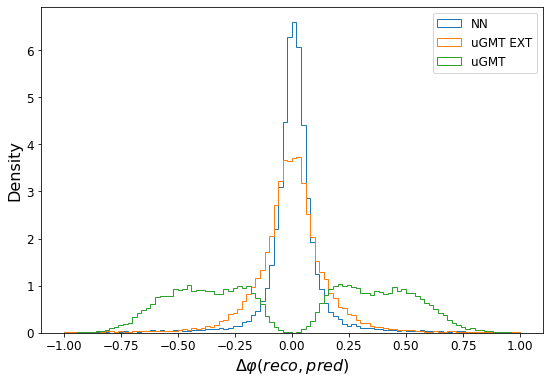

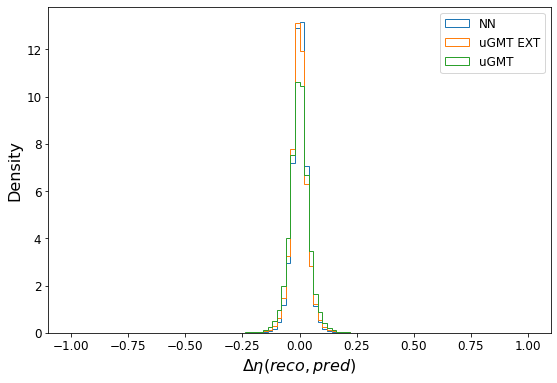

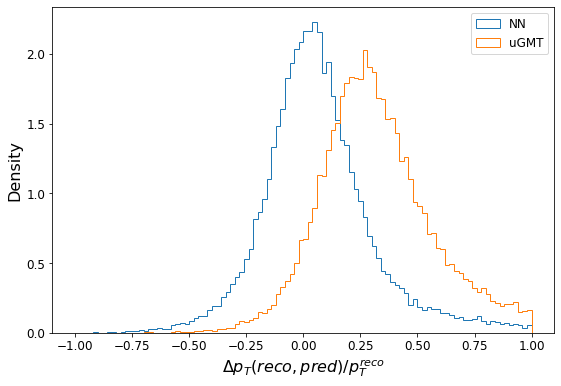

FWHM of delta_phi for the Neural Network Qkeras 0.12600000000000022
FWHM of delta_eta for the Neural Network Qkeras 0.06300000000000017
FWHM of delta_pt for the Neural Network Qkeras 0.41600000000000037


In [12]:
util.evaluate_keras(model = student,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = 64,
                   eta_div = 64,
                   pt_div = 64,
                   qual_div = 64,
                   batch_size = 2048)

In [13]:
y_pred = student.predict(x_test, batch_size=2048)
y_pred_teacher = teacher.predict(x_test, batch_size=2048)

y_pred = np.squeeze(y_pred)
y_pred_teacher = np.squeeze(y_pred_teacher)

y_pred[:,0] = inv_phi_range(np.array(y_pred[:,0])*phi_div)
y_pred_teacher[:,0] = inv_phi_range(np.array(y_pred_teacher[:,0])*phi_div)


delta_pt_pred =  y_pred[:,2] * pt_div * 0.5
delta_pt_pred_teacher =  y_pred_teacher[:,2] * pt_div * 0.5



pt_pred= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred[:])
pt_pred_teacher= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred_teacher[:])


delta_pt_p = np.array(pt_pred - df_test['ptRecoMu1'][:])
delta_pt_p_teacher = np.array(pt_pred_teacher - df_test['ptRecoMu1'][:])


In [14]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis["Teacher"] = np.abs(delta_pt_p_teacher/df_test['ptRecoMu1'])

df_analysis = df_analysis.sort_values(by=["X"])

In [15]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []
teacher_bin = []
teacher_bin_std = []
# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),0.5)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
    teacher = df_analysis["Teacher"][idx]
    
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    teacher_bin.append(teacher.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))
    teacher_bin_std.append(teacher.std()/np.sqrt(teacher.shape[0]))

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home

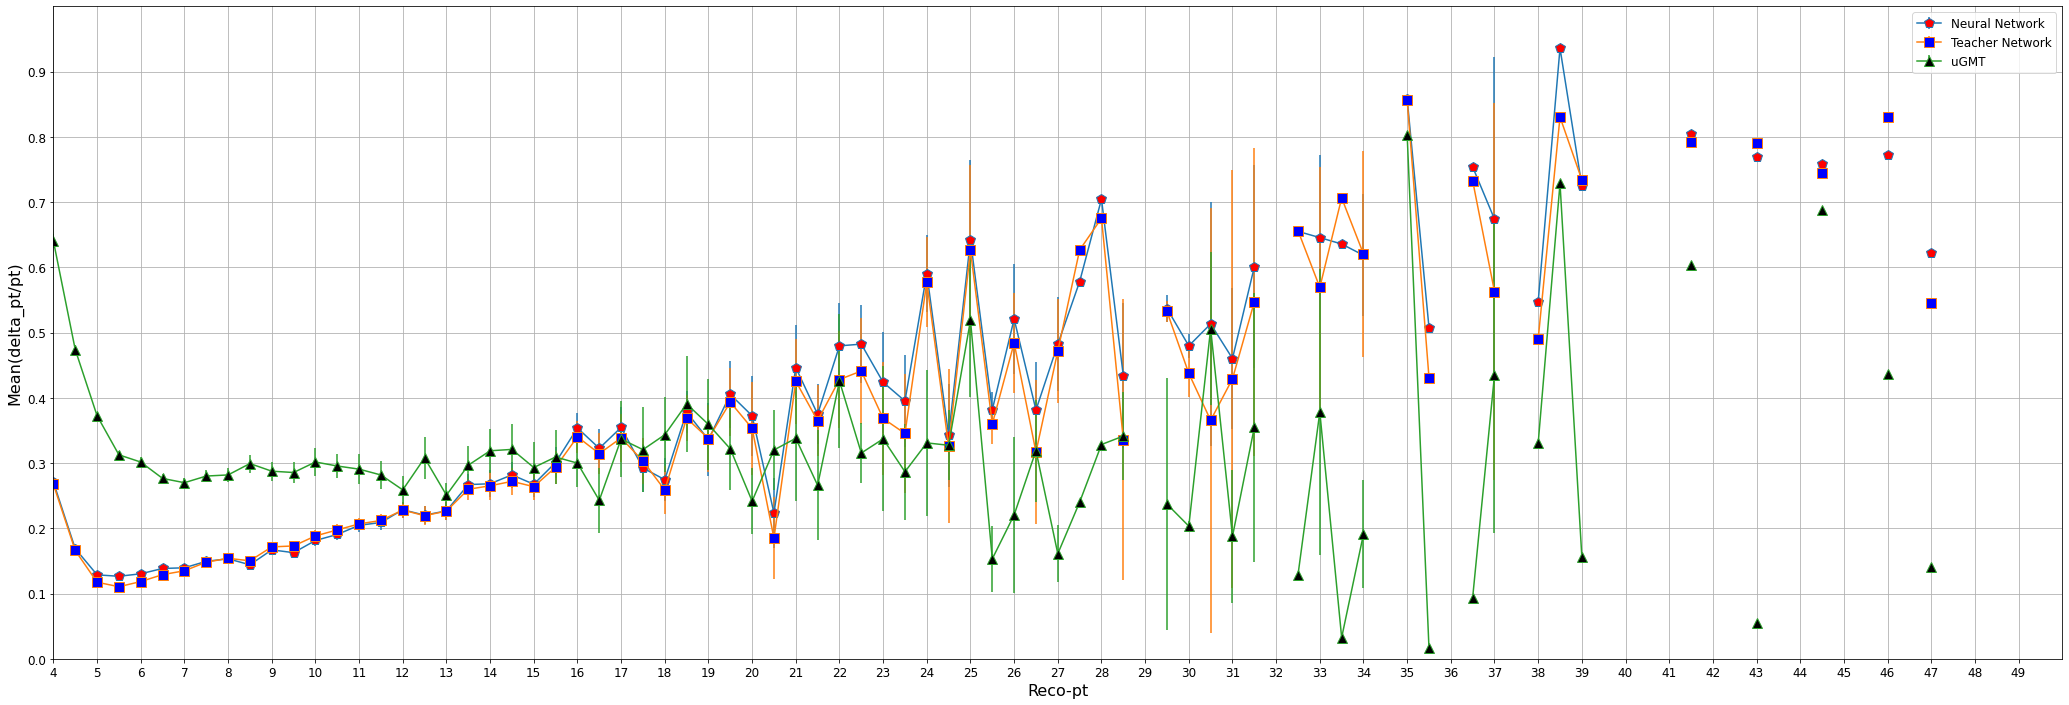

In [17]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
plt.errorbar(X_bin,teacher_bin, teacher_bin_std, label = "Teacher Network",marker = "s",markersize=10,mfc="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, 50, 1.0))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(4,50)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel("Reco-pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("fig1.pdf")

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


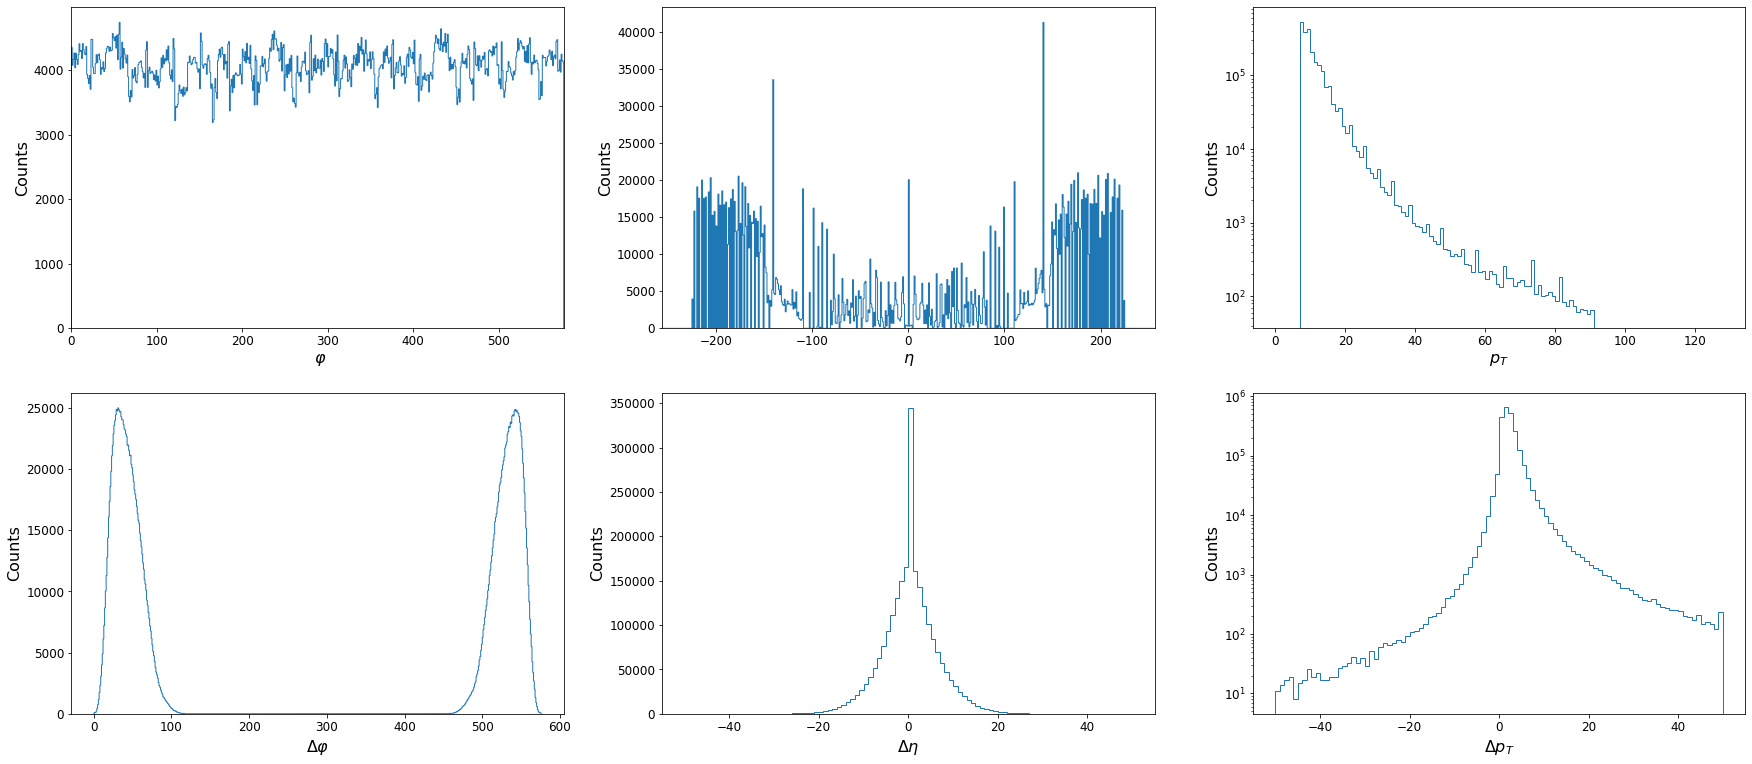

In [33]:
cut_lower = 18
cut_upper = 45
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])

# train_data_m, test_data_m, df_train_m, df_test_m = util.preprocess_data(df_base_minority)
df_train_m = util.apply_cut(df_train, cut_lower, cut_upper)
df_test_m = util.apply_cut(df_test, cut_lower, cut_upper)

idx_train = (df_train.hwPt2L1Mu1>cut_lower*2) * (df_train.hwPt2L1Mu1<cut_upper*2)
idx_test = (df_test.hwPt2L1Mu1>cut_lower*2) * (df_test.hwPt2L1Mu1<cut_upper*2)

x_train_m = x_train[idx_train] 
y_train_m = y_train[idx_train]
x_test_m = x_test[idx_test]
y_test_m = y_test[idx_test]

util.plot_data(df_base)

In [ ]:
## Loading a pretraiined corrector model, trained on the entire dataset.
## see PtCorrectorTraining.ipynb
corrector = tf.keras.models.load_model('corrector-recalibration/best/')

In [50]:
opt          = Adam(learning_rate=1e-4)
losses       = ['logcosh']
loss_weights = [1]

In [51]:
corrector.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hd1 (QDense)                 (None, 4)                 24        
_________________________________________________________________
bn1 (QBatchNormalization)    (None, 4)                 16        
_________________________________________________________________
act1 (QActivation)           (None, 4)                 0         
_________________________________________________________________
hd2 (QDense)                 (None, 4)                 20        
_________________________________________________________________
bn2 (QBatchNormalization)    (None, 4)                 16        
_________________________________________________________________
act2 (QActivation)           (None, 4)                 0         
_________________________________________________________________
hd3 (QDense)                 (None, 4)                

In [53]:

early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 20
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           factor=0.5,
                                                           patience=5,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.0001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    "./checkpoints/minor.h5",
    monitor           = 'val_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
callbacks = [
#     early_stopping,
#                  checkpoint,
             reduce_lr_on_plateu]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
        corrector.compile(
            loss         = losses,
            loss_weights = loss_weights,
            optimizer    = opt,
        #         metrics=[fwhm]
        )

        corrector.fit(
            x_train_m, y_train_m[:,2],
            callbacks=callbacks,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.1,
            shuffle=True,
            verbose = 1
            #callbacks = callbacks.callbacks
        )

Epoch 1/100
16/16 [==============================] - 2s 25ms/step - loss: 0.1041 - val_loss: 0.0405
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1031 - val_loss: 0.0513
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1020 - val_loss: 0.0605
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1010 - val_loss: 0.0675
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0999 - val_loss: 0.0726
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0989 - val_loss: 0.0767

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0981 - val_loss: 0.0798
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0976 - val_loss: 0.0825
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0971 - val_loss: 0.0844
Epoch 10/100
16/16 [=======

Epoch 72/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 73/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 74/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 75/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 76/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0932 - val_loss: 0.0924

Epoch 00076: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-09.
Epoch 77/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0932 - val_loss: 0.0924
Epoch 78/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 79/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 80/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0932 - val_loss: 0.0925
Epoch 81/100
16/16 

In [69]:
cut_lower = 1
y_pred = student.predict(x_test, batch_size=2048)
mask= x_test[:,2]>((cut_lower*2)/pt_div)
y_pred_corrected = corrector.predict(x_test,batch_size=2048)

In [70]:
y_pred[:,2] = y_pred[:,2]*(1-mask) + y_pred_corrected[:,0]*mask 

In [ ]:
y_pred = np.squeeze(y_pred)
y_pred[:,0] = inv_phi_range(np.array(y_pred[:,0])*phi_div)
delta_pt_pred =  y_pred[:,2] * pt_div * 0.5

In [ ]:
pt_pred= np.array(df_test['PtL1Mu1'] - delta_pt_pred)
delta_pt_p = np.array(pt_pred - df_test['ptRecoMu1'])

In [73]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])

df_analysis = df_analysis.sort_values(by=["X"])

In [74]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []
# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),0.5)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
    
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

In [75]:
# x = X_bin
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=32) 
# master = nn_bin
# masters = nn_bin_std

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home

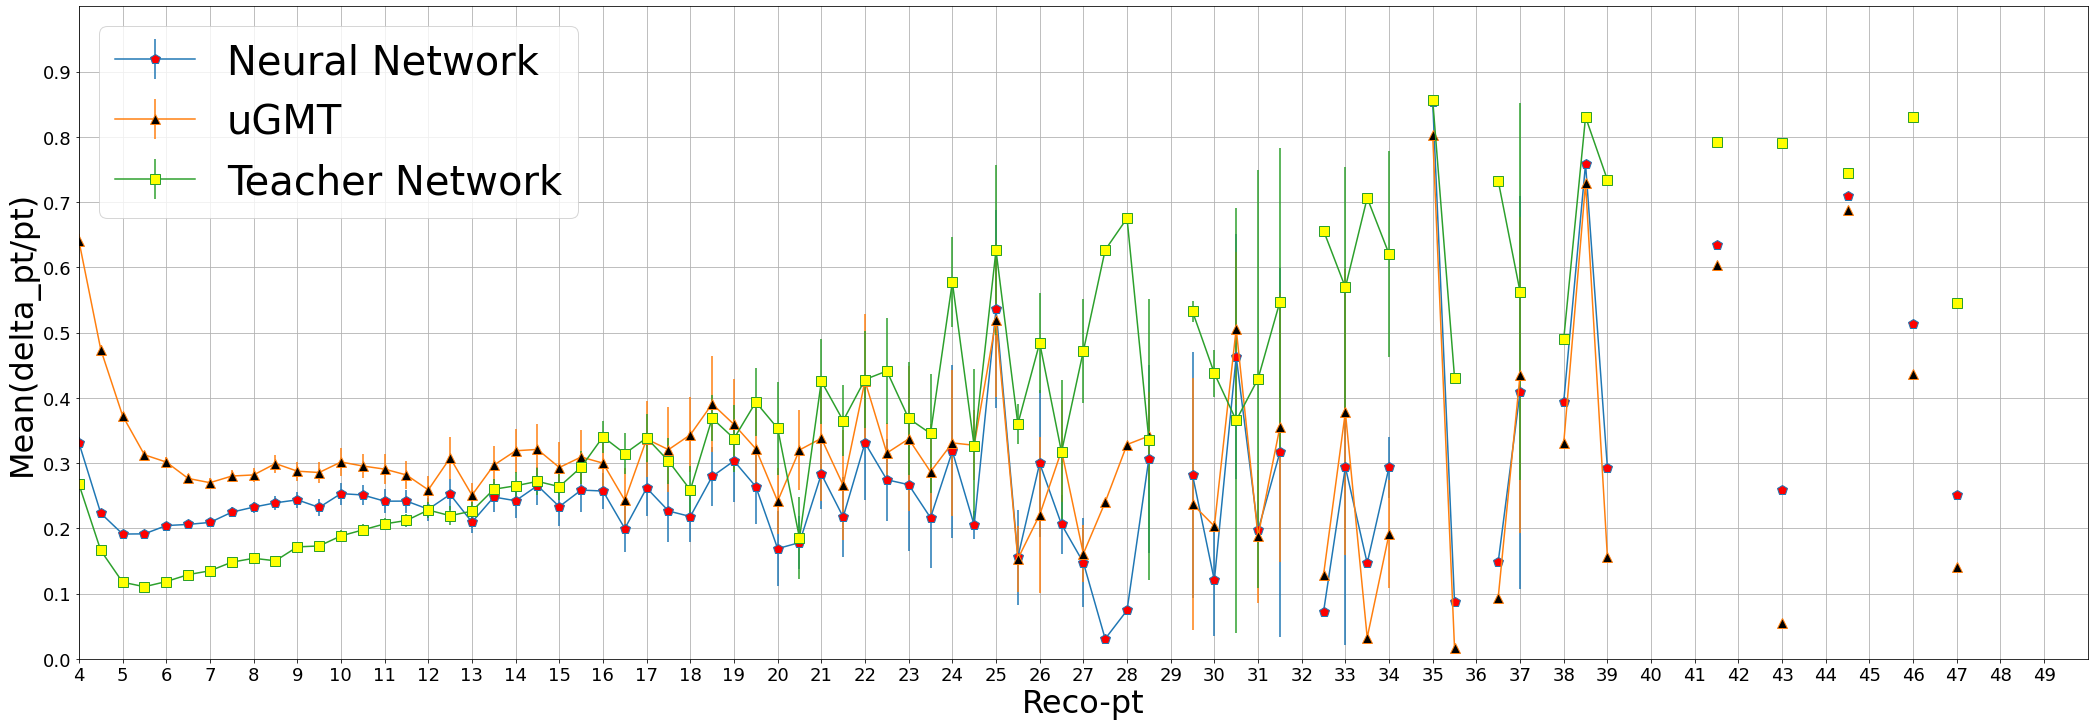

In [76]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
plt.errorbar(X_bin,teacher_bin, teacher_bin_std, label = "Teacher Network",marker = "s",markersize=10,mfc="yellow")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, 50, 1.0))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(4,50)
plt.ylim(0,1)
plt.grid(True)
plt.legend(fontsize="40")
plt.xlabel("Reco-pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Two_models.pdf")

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


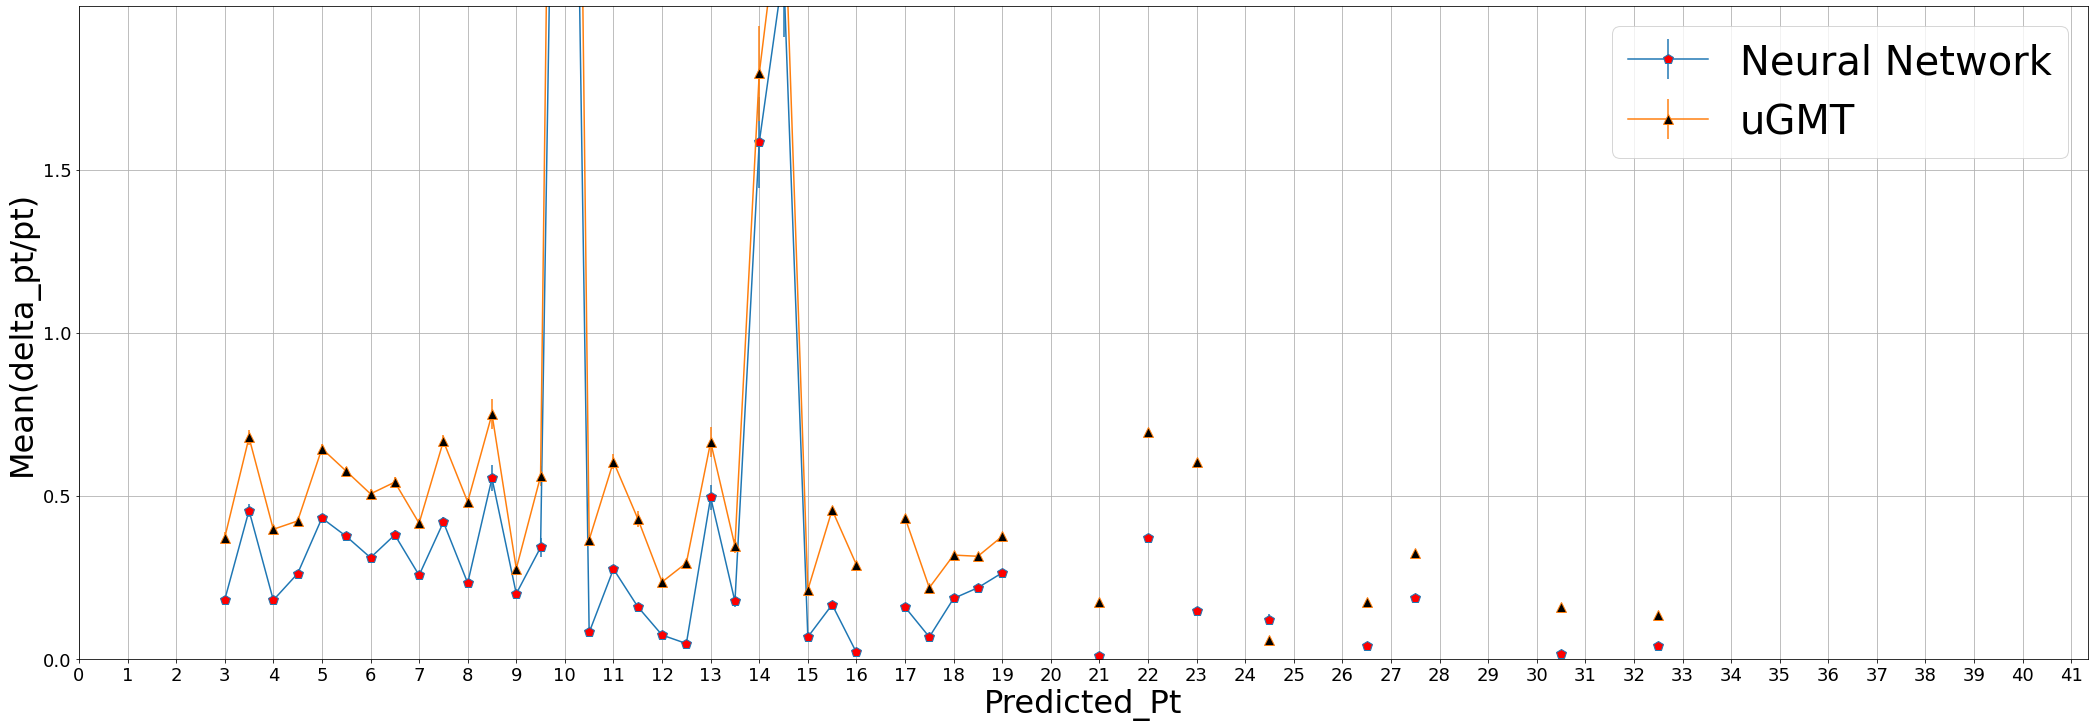

In [77]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = pt_pred
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),0.5)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

    
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, df_analysis["X"].max(), 1))
plt.yticks(np.arange(0, 2, 0.5))
plt.xlim(0, df_analysis["X"].max())
plt.ylim(0,2)
plt.grid(True)
plt.legend(fontsize="40")
plt.xlabel("Predicted_Pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Predicted_pt_2_models.pdf")